In [1]:
# limit the thread used by numpy for better parallelization
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import *
from Triangle.GW import *
from Triangle.Cosmology import LuminosityDistance, z_dl

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

import multiprocessing
# if __name__ == "__main__":
#     multiprocessing.set_start_method("fork")
# print("number of cpus =", multiprocessing.cpu_count())
# pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## Set parameters 

In [3]:
parameters = {
    'chirp_mass': np.power(10., np.random.uniform(5, 7)),
    'coalescence_phase': 4.618102360940744,
    'coalescence_time': 12., # fix to the 12 th day 
    'inclination': 1.8709099988987916,
    'latitude': -0.6806154941973864,
    'longitude': 2.8373429551400404,
    'luminosity_distance': np.power(10., np.random.uniform(4.5, 5)),
    'mass_ratio': np.random.uniform(0.1, 0.999),
    'psi': 1.6782894010201774,
    'spin_1z': np.random.uniform(-0.99, 0.99),
    'spin_2z': np.random.uniform(-0.99, 0.99)
    }
parameters

{'chirp_mass': 988593.3730767024,
 'coalescence_phase': 4.618102360940744,
 'coalescence_time': 12.0,
 'inclination': 1.8709099988987916,
 'latitude': -0.6806154941973864,
 'longitude': 2.8373429551400404,
 'luminosity_distance': 97009.84364501118,
 'mass_ratio': 0.9324444761835801,
 'psi': 1.6782894010201774,
 'spin_1z': -0.13233003246609265,
 'spin_2z': -0.7445920613959812}

## Global settings 

In [4]:
Tobs = 15 * DAY 
dt = 5

orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")

# approx = "SEOBNRv4_opt"
approx = "IMRPhenomT"
# approx = "IMRPhenomD"

pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

## Simulate with ``Interferometers.SimulateGW``

In [5]:
# data size and interpolation order 
size = int(Tobs / dt)
interp_order = 15 

# nuisance for GW sinal 
offset = OffsetFunctions(laser_flag=False, clock_flag=False)
noise = InstrumentalPSDs(L=L_nominal)

# initialize GW waveform and response 
gw_mbhb = Initialize_GW_response(
    signal_type="MBHB",
    parameters=parameters,
    orbit=orbit,
    approximant=approx,
)

# simulate raw interferometric measurements (noiseless)
ifo = Interferometers(
    size=size,
    fsample=1./dt,
    time_frame="ProperTime",  # the time frame of data, 'ProperTime' for the proper times of SCs, 'ClockTime' for the times of on-board clocks (with clock drifts and jitters), default is "ProperTime".
    acc_noise=False,  # switch of acceleration noise, default is True (this default value also applies to other noises).
    ro_noise=False,  # switch of readout noise
    laser_noise=False,  # switch of laser frequency noise
    clock_noise=False,  # switch of clock noise
    ob_noise=False,  # switch of optical bench displacement noise
    bl_noise=False,  # switch of fibre backlink noise
    op_noise=False,  # switch of optical path noise (all optical paths)
    ranging_noise=False,  # switch of pseudo ranging noise
    modulation_noise=False,  # switch of sideband modulation noise
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=gw_mbhb,
    fplan=None,
    order=interp_order,
    pool=pool,
    clean_memory=True,  # whether to clean some intermediate variables to save memory
)

# simulate, output, and sync to TCB 
ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode="decomposed")
m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool)
ifo.clean()
print("raw data:", m1.keys())

# TDI 
tdi = TDI(measurements=m1, delays=m1["ltt"], fsample=m1["fsample"], order=interp_order)
tdi.CalculateXi(doppler=True, pool=pool)
tdi.CalculateEta(doppler=True)
tdi.FastMichelson(doppler=True, channel="AET")
print("TDI data:", tdi.measurements.keys())

initializing responses.


100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

responses initialized.


raw data: dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b'])
TDI data: dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X0', 'X1', 'X2', 'Y0', 'Y1', 'Y2', 'Z0', 'Z1', 'Z2', 'A0', 'E0', 'T0', 'A1', 'E1', 'T1', 'A2', 'E2', 'T2'])


In [6]:
time_ifo = tdi.measurements["time"]["1"].copy() 
wf_ifo = np.array([
    tdi.measurements["A2"],
    tdi.measurements["E2"], 
    tdi.measurements["T2"], 
]) / F_LASER
wf_ifo[:, :int(1000./dt)] = 0. 
wf_ifo[:, -int(1000./dt):] = 0. 
time_ifo.shape, wf_ifo.shape 

((259200,), (3, 259200))

## Simulate with ``GeneralTDIResponse``

### (1) initialization stage 

In [7]:
time_gen = np.arange(int(Tobs/dt), dtype=np.float64) * dt 

mbhb_waveform_generator = MBHB_Injection(approx_method=approx, buffer=True)

A2_string, E2_string, T2_string = TDIStringManipulation.AETStringsfromXString(GeneralTDIResponse.X2_strings)
A_gen_generator = GeneralTDIResponse(
    orbit=orbit, 
    Pstring=A2_string, 
    tcb_times=time_gen.copy(),
    use_gpu=False, 
    drop_points=int(1000./dt), 
    linear_interp=False, 
    return_eta=False, 
)
E_gen_generator = GeneralTDIResponse(
    orbit=orbit, 
    Pstring=E2_string, 
    tcb_times=time_gen.copy(),
    use_gpu=False, 
    drop_points=int(1000./dt), 
    linear_interp=False, 
    return_eta=False, 
)
T_gen_generator = GeneralTDIResponse(
    orbit=orbit, 
    Pstring=T2_string, 
    tcb_times=time_gen.copy(),
    use_gpu=False, 
    drop_points=int(1000./dt), 
    linear_interp=False, 
    return_eta=False, 
)

### (2) generation stage 

In [8]:
# calculate 10 times for speed test (no parallelization)
for _ in tqdm(range(10)):
    wf_gen = np.array([
        A_gen_generator(parameters=parameters, waveform_generator=mbhb_waveform_generator), 
        E_gen_generator(parameters=parameters, waveform_generator=mbhb_waveform_generator), 
        T_gen_generator(parameters=parameters, waveform_generator=mbhb_waveform_generator), 
    ])

time_gen.shape, wf_gen.shape 

100%|██████████| 10/10 [00:38<00:00,  3.89s/it]


((259200,), (3, 259200))

## Simulate with ``FastMichelsonResponse``

### (1) Initialization stage 

In [13]:
time_mich = np.arange(int(Tobs/dt), dtype=np.float64) * dt 

AET_mich_generator = FastMichelsonTDIResponse(
    orbit=orbit, 
    tcb_times=time_mich.copy(), 
    use_gpu=False, 
    drop_points=int(1000./dt), 
    interp_method="Spline5",  # use a safe interp order to ensure accuracy 
)

### (2) generation stage 

In [14]:
# calculate 10 times for speed test (no parallelization)
for _ in tqdm(range(10)):
    wf_mich = AET_mich_generator(parameters=parameters, waveform_generator=mbhb_waveform_generator, optimal_combination=True)

time_mich.shape, wf_mich.shape 

100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


((259200,), (3, 259200))

## Compare against the benchmark ``Interferometers`` method 

In [35]:
channel_names = ["A2", "E2", "T2"]

### (1) General

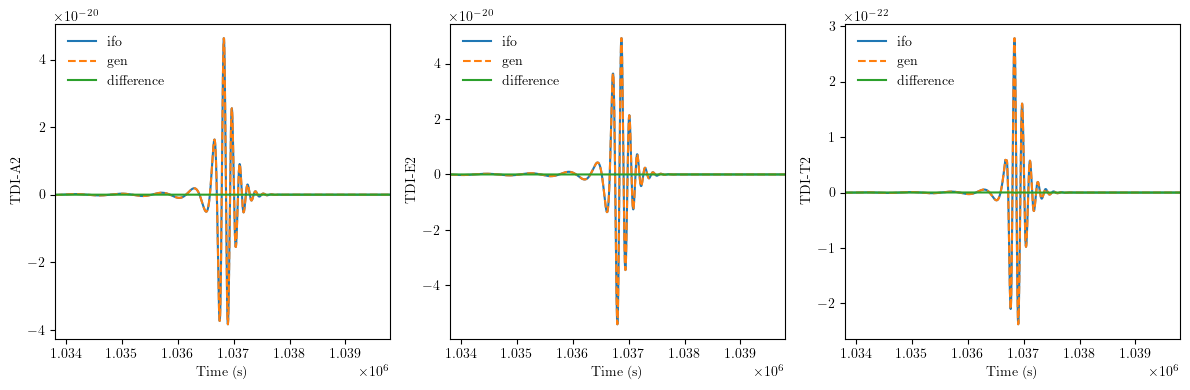

In [42]:
plt.figure(figsize=(12, 4))
for ich, nch in enumerate(channel_names):
    plt.subplot((131+ich))
    plt.plot(time_ifo, wf_ifo[ich], label="ifo")
    plt.plot(time_gen, wf_gen[ich], label="gen", linestyle="--")
    plt.plot(time_ifo, wf_ifo[ich] - wf_gen[ich], label="difference")
    plt.xlabel("Time (s)")
    plt.ylabel("TDI-"+nch)
    plt.legend(loc="upper left", frameon=False)
    plt.xlim(parameters["coalescence_time"]*DAY-3000, parameters["coalescence_time"]*DAY+3000)
plt.tight_layout()

In [43]:
plot_freqs = np.logspace(-5, 0, 1000)
arms = dict() # arm at tc 
for key in MOSA_labels: 
    arms[key] = orbit.LTTfunctions()[key](parameters["coalescence_time"]*DAY)
arms = MOSADict(arms)
PSDfunc = TDIPSDs()
plot_psds = np.array([
    PSDfunc.PSD_A2_unequal(f=plot_freqs, arms=arms), 
    PSDfunc.PSD_E2_unequal(f=plot_freqs, arms=arms), 
    PSDfunc.PSD_T2_unequal(f=plot_freqs, arms=arms), 
])
plot_freqs.shape, plot_psds.shape 

((1000,), (3, 1000))

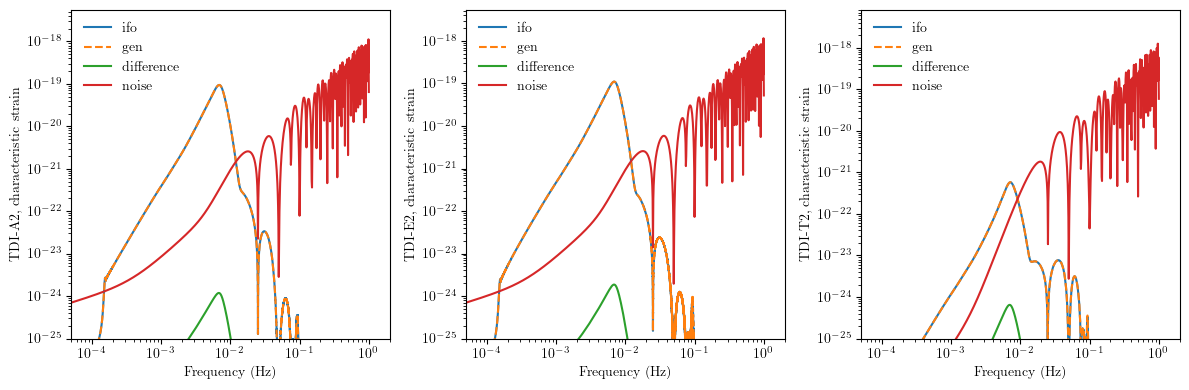

In [44]:
plt.figure(figsize=(12, 4))
for ich, nch in enumerate(channel_names):
    plt.subplot((131+ich))
    ff, xf_ifo = FFT_window(wf_ifo[ich], 1./dt)
    plt.loglog(ff, np.abs(xf_ifo) * 2. * ff, label="ifo")
    ff, xf_gen = FFT_window(wf_gen[ich], 1./dt)
    plt.loglog(ff, np.abs(xf_gen) * 2. * ff, label="gen", linestyle="--")
    plt.loglog(ff, np.abs(xf_ifo - xf_gen) * 2. * ff, label="difference")
    plt.loglog(plot_freqs, np.sqrt(plot_psds[ich] * plot_freqs), label="noise")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("TDI-"+nch+", characteristic strain")
    plt.legend(loc="upper left", frameon=False)
    plt.ylim(1e-25,)
    plt.xlim(5e-5,)
plt.tight_layout()

### (2) Michelson

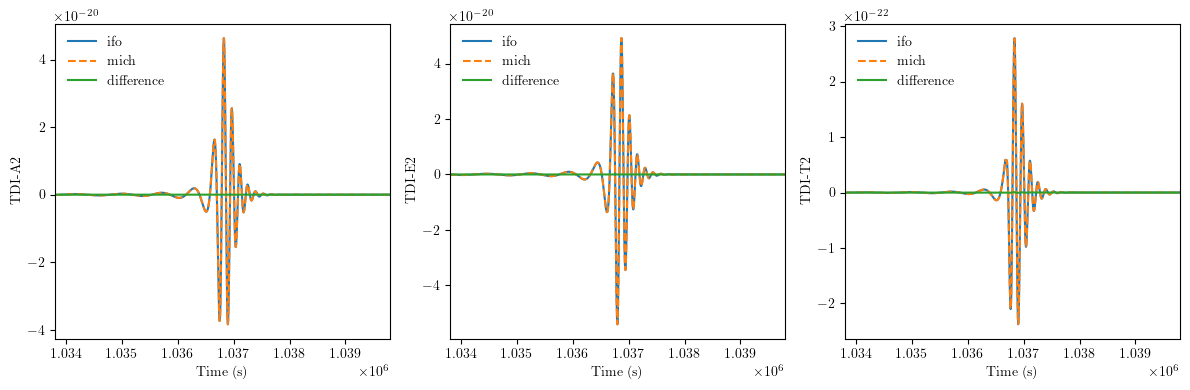

In [45]:
plt.figure(figsize=(12, 4))
for ich, nch in enumerate(channel_names):
    plt.subplot((131+ich))
    plt.plot(time_ifo, wf_ifo[ich], label="ifo")
    plt.plot(time_mich, wf_mich[ich], label="mich", linestyle="--")
    plt.plot(time_ifo, wf_ifo[ich] - wf_mich[ich], label="difference")
    plt.xlabel("Time (s)")
    plt.ylabel("TDI-"+nch)
    plt.legend(loc="upper left", frameon=False)
    plt.xlim(parameters["coalescence_time"]*DAY-3000, parameters["coalescence_time"]*DAY+3000)
plt.tight_layout()

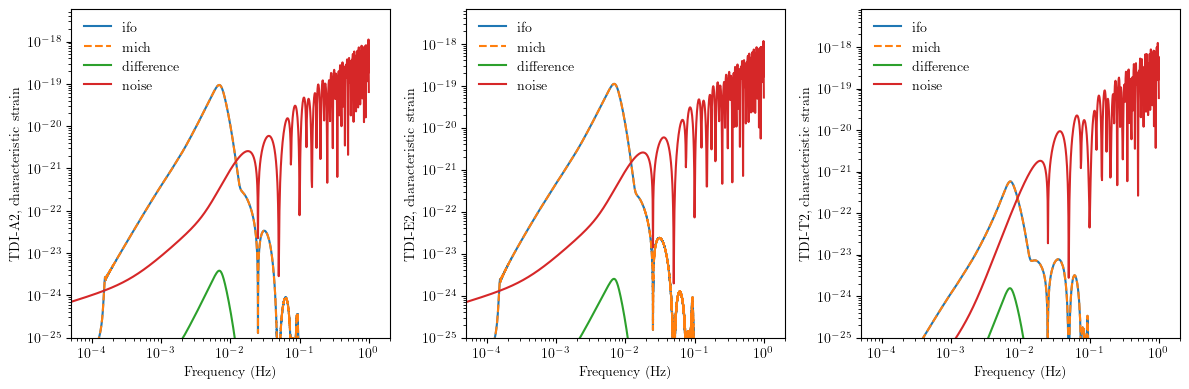

In [46]:
plt.figure(figsize=(12, 4))
for ich, nch in enumerate(channel_names):
    plt.subplot((131+ich))
    ff, xf_ifo = FFT_window(wf_ifo[ich], 1./dt)
    plt.loglog(ff, np.abs(xf_ifo) * 2. * ff, label="ifo")
    ff, xf_mich = FFT_window(wf_mich[ich], 1./dt)
    plt.loglog(ff, np.abs(xf_mich) * 2. * ff, label="mich", linestyle="--")
    plt.loglog(ff, np.abs(xf_ifo - xf_mich) * 2. * ff, label="difference")
    plt.loglog(plot_freqs, np.sqrt(plot_psds[ich] * plot_freqs), label="noise")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("TDI-"+nch+", characteristic strain")
    plt.legend(loc="upper left", frameon=False)
    plt.ylim(1e-25,)
    plt.xlim(5e-5,)
plt.tight_layout()